In [290]:
import numpy as np
import scipy.ndimage.filters

def make_metaball(vsize, num_points=5, alpha=1, beta=0.2, cutoff=1, blur_sigma=0.7):
    grid = np.indices(vsize).astype(np.float32)
    field = np.zeros(vsize)

    for n in range(num_points):
        center = np.random.uniform(8,24,3)
        #center = np.random.normal(vsize/2, 4)
        g = grid - center[:,None,None,None]
        field += alpha * np.exp(- beta * np.sqrt(np.sum(np.square(g), axis=0)) )
        #print(center)

        result = (field > cutoff).astype(np.float32)
        result = scipy.ndimage.filters.gaussian_filter(result, sigma=blur_sigma)
    return result

In [291]:
def make_wall(vsize, blur_sigma=0.5, radius=64):
    grid = np.indices(vsize).astype(np.float32)
    field = np.zeros(vsize)

    wall_dir = np.random.normal(size=3)
    wall_dir /= np.sqrt(np.sum(np.square(wall_dir)))
    center = np.random.uniform(0,vsize[0],3) + radius * wall_dir
    g = grid - center[:,None,None,None]
    dist =  np.sqrt(np.sum(np.square(g), axis=0))

    result = (dist > radius).astype(np.float32)
    result = scipy.ndimage.filters.gaussian_filter(result, sigma=blur_sigma)
    return result

In [174]:
import noise

def make_noise(vsize, freq=16.0, octaves=4, persistence=0.5, lacunarity=2.0):
    result = np.zeros(vsize)
    octaves = 8
    freq = freq * octaves
    for i in range(vsize[0]):
        for j in range(vsize[1]):
            for k in range(vsize[2]):
                result[i,j,k] = noise.snoise3(i/freq, j/freq, k/freq, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
    return result

In [40]:
from pylab import *
%matplotlib inline

In [214]:
def imshow_grid(images, nx=8, ny=4):
    sy, sx = images[0].shape[0], images[0].shape[1]
    big_image = np.zeros((sy*ny, sx*nx))
    iy, ix = 0, 0
    for k, image in enumerate(images):
        big_image[iy*sy:(iy+1)*sy, ix*sx:(ix+1)*sx] = image
        ix += 1
        if ix == nx:
            iy += 1
            ix = 0
    imshow(big_image, cmap='gray')
    show()

In [ ]:
import scipy.ndimage.interpolation

In [269]:
def make_combo():
    vsize = np.asarray((32,32,32))
    wall = make_wall(vsize*2, radius=120)
    wall = scipy.ndimage.interpolation.zoom(wall, 0.5, order=1)
    blob = make_metaball(vsize)
    result = np.amax(np.stack((blob*700, wall*1000)), axis=0)
    result += np.abs(make_noise(vsize, freq=4, octaves=3, persistence=0.9))*300
    return result

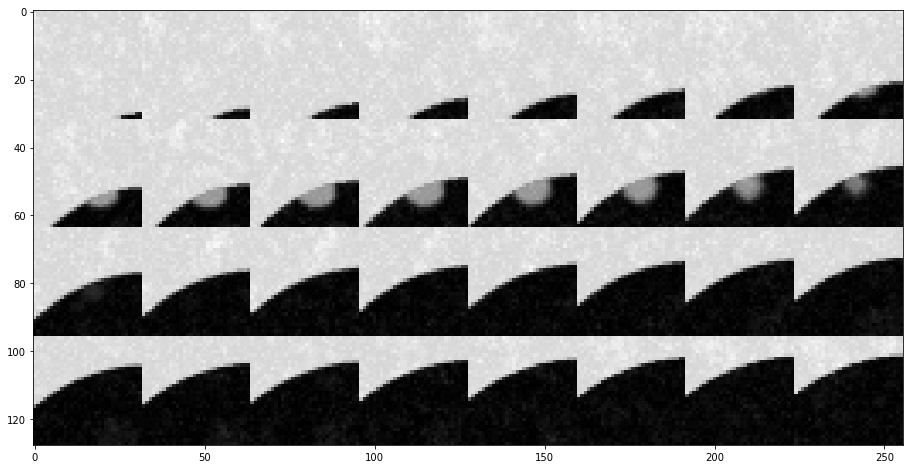

In [301]:
result = make_combo()
# result = scipy.ndimage.interpolation.zoom(result, 0.5, order=1)
figure(figsize=(16,8))
imshow_grid( [ result[x] for x in range(32)] )

In [298]:
%timeit make_wall(vsize, radius=60)

1000 loops, best of 3: 1.02 ms per loop


In [328]:
tmp = make_noise(vsize, freq=2, octaves=3, persistence=0.5)
#h = hist(np.abs(tmp).ravel(), bins=50)

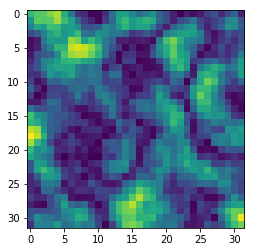

In [329]:
imshow(np.abs(tmp[16]))

In [331]:
import data

/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [339]:
mask = data.compose_make_mask_gaussian(vsize, sigma=6)

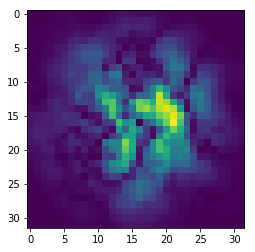

In [342]:
imshow(np.abs((tmp*mask)[16]))

In [520]:
def make_wall_concentric(vsize, blur_sigma=0.7, radius=120, center_radius=10):
    grid = np.indices(vsize).astype(np.float32)

    wall_dir = np.random.normal(size=3)
    wall_dir /= np.sqrt(np.sum(np.square(wall_dir)))
    center = vsize/2 + (radius - center_radius) * wall_dir
    g = grid - center[:,None,None,None]
    dist =  np.sqrt(np.sum(np.square(g), axis=0))

    result = (dist > radius).astype(np.float32)
    result = scipy.ndimage.filters.gaussian_filter(result, sigma=blur_sigma)
    return result

In [521]:
def make_sphere(vsize, blur_sigma=0.7, radius=10):
    grid = np.indices(vsize).astype(np.float32)

    wall_dir = np.random.normal(size=3)
    wall_dir /= np.sqrt(np.sum(np.square(wall_dir)))
    center = vsize/2
    g = grid - center[:,None,None,None]
    dist =  np.sqrt(np.sum(np.square(g), axis=0))

    result = (dist < radius).astype(np.float32)
    result = scipy.ndimage.filters.gaussian_filter(result, sigma=blur_sigma)
    return result

In [372]:
tmp_noise = scipy.ndimage.filters.gaussian_filter(np.random.normal(size=vsize)*0.4, sigma=1)
tmp = make_wall_concentric(vsize) + make_sphere(vsize) + tmp_noise

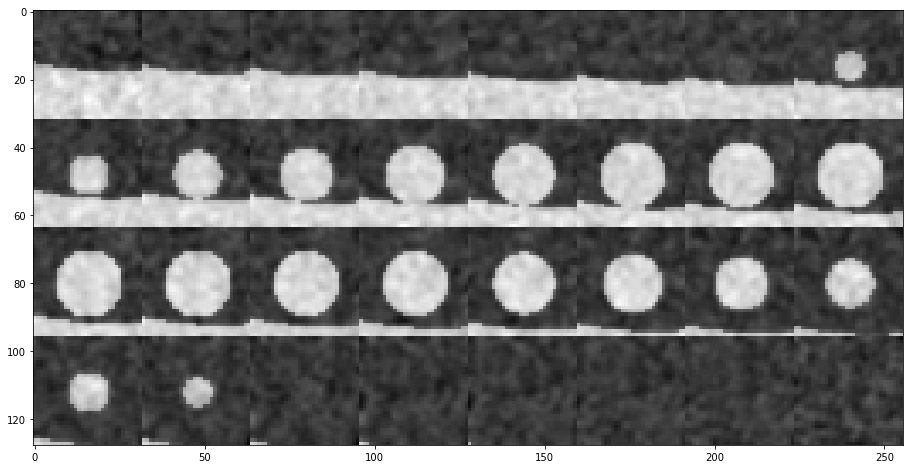

In [373]:
figure(figsize=(16,8))
imshow_grid( [ tmp[x] for x in range(32)] )

In [509]:
def make_simple_positive_sample():
    sphere_radius = np.random.uniform(5,12)
    wall_radius = np.random.uniform(60,200)
    center_radius = np.random.uniform(0,sphere_radius*1.5)
    sphere_density = 1000 + np.random.uniform(-100, 80)
    wall_density = 1000 + np.random.uniform(50, 80)
    noise_density = np.random.uniform(200, 1000)
    
    background_density = 1000 + np.random.uniform(-950, -800)
    image = np.ones(vsize, dtype=np.float32) * background_density
    image = np.maximum( image, make_wall_concentric(vsize, radius=wall_radius, center_radius=center_radius) * wall_density)
    image = np.maximum( image, make_sphere(vsize, radius=sphere_radius) * sphere_density )
    image += noise_density * scipy.ndimage.filters.gaussian_filter(np.random.normal(size=vsize)*0.4, sigma=1)
    return image - 1000

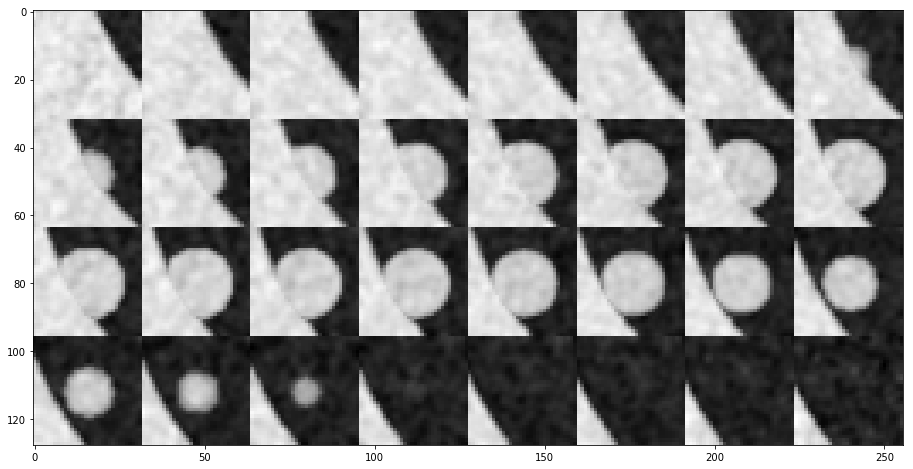

In [523]:
image = make_simple_positive_sample()
figure(figsize=(16,8))
imshow_grid( [ image[x] for x in range(32)] )

In [456]:
%timeit make_simple_positive_sample()

100 loops, best of 3: 4.12 ms per loop


In [558]:
def make_simple_negative_sample():
    wall_radius = np.random.uniform(60,200)
    center_radius = np.random.uniform(-vsize[0],vsize[0])
    wall_density = 1000 + np.random.uniform(50, 80)
    noise_density = np.random.uniform(200, 1000)
    
    background_density = 1000 + np.random.uniform(-950, -800)
    image = np.ones(vsize, dtype=np.float32) * background_density
    image = np.maximum( image, make_wall_concentric(vsize, radius=wall_radius, center_radius=center_radius) * wall_density)
    image += noise_density * scipy.ndimage.filters.gaussian_filter(np.random.normal(size=vsize)*0.4, sigma=1)
    return image - 1000

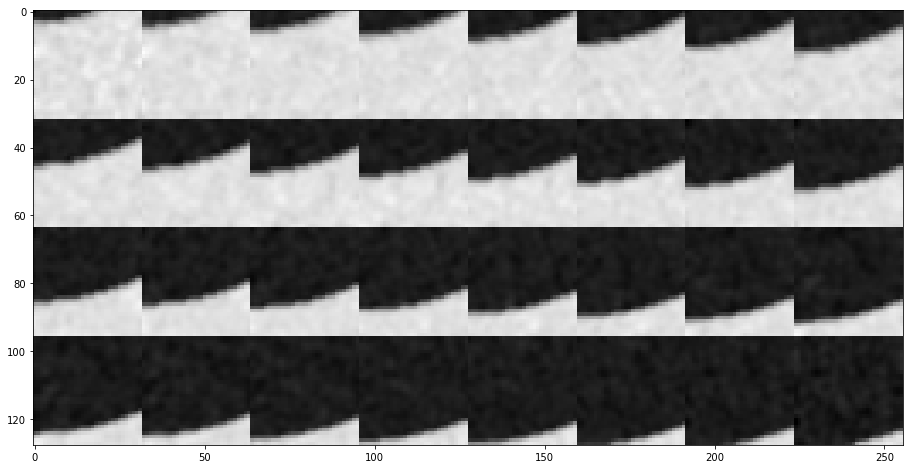

In [561]:
image = make_simple_negative_sample()
figure(figsize=(16,8))
imshow_grid( [ image[x] for x in range(32)] )

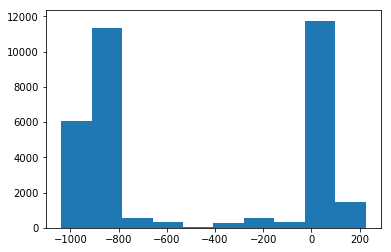

In [562]:
h = hist(image.ravel())

In [563]:
X_negative = [ make_simple_negative_sample().astype(np.int16) for n in range(10000) ]
X_positive = [ make_simple_positive_sample().astype(np.int16) for n in range(10000) ]
X = np.stack(X_negative + X_positive).astype(np.int16)
np.save("/mnt/data/luna16/sets/synth_set_v1_20k.npy", X[:,:,:,:,None])